Filename:     main.py 

Description:  main function for the poisson solver project

Author:       Nithin Adiddela

Created:      2025 April 02

Modified:     2025 April 08

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import latex newcommands
$$
\providecommand{\grad}[1]{\nabla{#1}}
\providecommand{\lapl}[1]{\nabla^2{#1}}
\providecommand{\pd}[2]{\frac{\partial#1}{\partial#2}}
\providecommand{\pdd}[2]{\frac{\partial^2#1}{\partial#2^2}}
$$

## Poisson's equation
Poisson's equation in variable u with sources f is written as
$$
\lapl(u) = f.
$$
It is posed as a boundary value problem (BVP) in 2D with the ODE
$$
\pdd{u}{x} + \pdd{u}{x} = f \,\, \forall \,\, 0 < x, y < L,
$$
where L is the length of the domain, and with the boundary conditions (BCs)
$$
u = g  \,\, \forall \,\, x = y = 0 \,\, \& \,\, x, y = L,
$$
where g could be any constant or time-dependant function. 


In [2]:
'''Length of the domain'''
L = 1.0
''' No. of interior grid points in each dimension '''
N = 2**5
''' No. of exterion (ghost) points in each dimension '''
G = 2
''' No. of total grid points in each dimension ''' 
NpG = N + G 
''' Grid spacing '''
dx = (L - 0) / (N + 1)
''' Grid lines '''
x = np.linspace(0, L, NpG)
y = np.linspace(0, L, NpG)
''' Meshgrid '''
X, Y = np.meshgrid(x, y)

## Benchmark problem
Let us develop numerical methods to solve this equation with the following benchmark problem: 
$$
u = sin(\frac{2 \pi x}{L}) cos(\frac{2 \pi x}{L}), 
$$
which implies that $f \equiv \lapl{u} = $
$$
f = - 4 \frac{\pi^2}{L^2} (sin(\frac{4 \pi x}{L}) cos(\frac{4 \pi x}{L})),
$$
and the boundary conditions will consequentially be
$$
u_{x=0, \,y} = 0 = u_{x=L, \,y},
$$
at left, right, and 
$$
u_{x, \,y=0} = cos(2 \pi \frac{x}{L}) = u_{x, \,y=L},
$$
at bottom and top, respectively.

As a result the BC matrix g is initialized to 0 everywhere and give the values
$$
\begin{align}
g_{x=0, \,y} &= 0, \\
g_{x=L, \,y} &= 0, \\
g_{x, \,y=0} &= cos(2 \pi \frac{x}{L}), \\
g_{x, \,y=L} &= cos(2 \pi \frac{x}{L}). 
\end{align}
$$

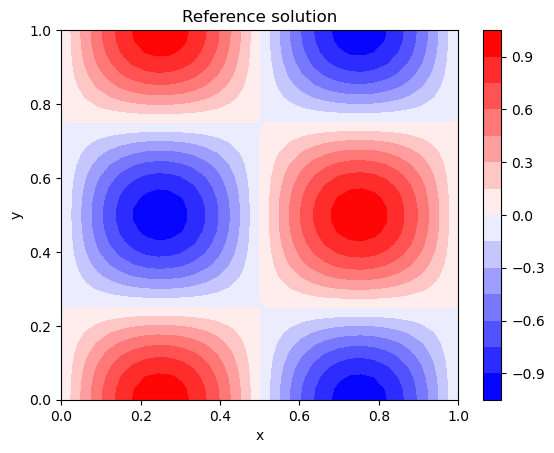

In [3]:
''' Benchmark problem '''
freq = 2.
f = -2. * freq**2 * np.pi**2 * np.sin(freq * np.pi * (X / L)) * np.cos(freq * np.pi * (Y / L))
u_ref = np.sin(freq * np.pi * (X / L)) * np.cos(freq * np.pi * (Y / L))

'''Plot reference solution'''
plt.figure()
plt.contourf(X, Y, u_ref, levels=16, cmap='bwr',  vmin=-1, vmax=1)
plt.colorbar()
plt.title('Reference solution')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [4]:
'''Boundary conditions (BC)'''
'''Dirichlet BCs (consequence of choice of f in this Benchmark problem)'''
def set_BC_Dirichlet(t_u, t_x, t_y):
    '''rows is y, columns is x'''
    '''Bottom: row 0'''
    t_u[0, :] = np.sin(freq * np.pi * t_x / L)
    '''Top'''
    t_u[-1, :] = np.sin(freq * np.pi * t_x / L)
    '''Left'''
    t_u[:, 0] = 0.
    '''Right'''
    t_u[:, -1] = 0.

'''BC matrix'''
g = np.zeros((NpG, NpG))
set_BC_Dirichlet(g, x, y)

# Discretization

We discretize the $2^{nd}$ order derivative ODE using central difference on a 2D grid with,
$$
\Delta x = \Delta y = L / (N + 1),
$$
where N is the number of internal points to get,
$$
(u_{i+1, j} + u_{i-1, j} - 2 u_{i, j}) + (u_{i, j+1} + u_{i, j-1} - 2 u_{i, j}) = f_{i, j} \Delta x^2.
$$
For the point $u_{1,1}$, which is the SW (South-West) most grid point, it looks like
$$
(u_{2, 1} + u_{0, 1} - 2 u_{1, 1}) + (u_{1, 2} + u_{1, 0} - 2 u_{1, 1}) = f_{1, 1} \Delta x^2, 
$$ 
which can be rearranged to get 
$$
  - 4 u_{1, 1} + u_{2, 1} + u_{1, 2} = f_{1, 1} \Delta x^2 - (g_{0, 1} + g_{1, 0}) 
$$
For the point $u_{i,1}$ (1 <= i <= N-1), which is the bottom line on the interior, it looks like
$$
(u_{i+1, 1} + u_{i-1, 1} - 2 u_{i, 1}) + (u_{i, 2} + u_{i, 0} - 2 u_{i, 1}) = f_{i, 1} \Delta x^2, 
$$ 
which can be rearranged to get 
$$
  u_{i-1, 1} - 4 u_{i, 1} + u_{i+1, 1} + u_{i, 2} = f_{1, 1} \Delta x^2 - g_{i, 0} 
$$


# Dense matrix inversion

Now that we have a discretized equation, it is time to represent it in a linear algebra form A u = b, where
A is a matrix of dimensions $N^2 \times N^2$, x and b are vectors of dimension $N^2 \times 1$.

In [5]:
''' Initialize A_mat_dense, u_vec, b_vec '''
A_mat_dense = np.zeros((N**2, N**2))
u_vec = np.zeros(N**2)
b_vec = np.zeros(N**2)

k = 0  # flat index
for i in range(1, N+1):      # corresponds to interior rows
    for j in range(1, N+1):  # corresponds to interior cols
        k = (i - 1) * N + (j - 1) # flat index

        b_vec[k] = f[i, j] * dx**2 - (  g[i-1, j]  # top
                                      + g[i+1, j]  # bottom
                                      + g[i, j-1]  # left
                                      + g[i, j+1]  # right
                                      )
        A_mat_dense[k, k] = -4.0

        if j > 1:
            A_mat_dense[k, k-1] = 1.0
        if j < N:
            A_mat_dense[k, k+1] = 1.0
        if i > 1:
            A_mat_dense[k, k-N] = 1.0
        if i < N:
            A_mat_dense[k, k+N] = 1.0

Text(0.5, 1.0, 'Numerical solution')

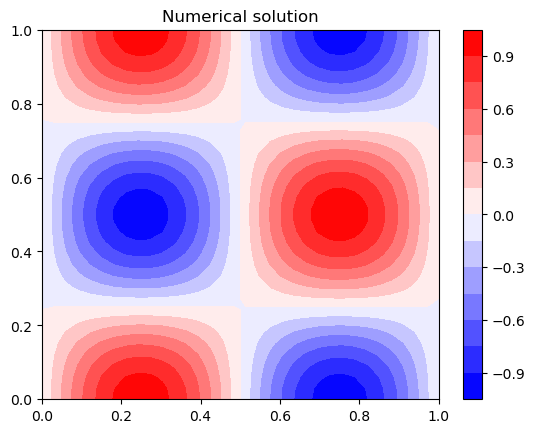

In [6]:
'''solve for u_vec = A_mat_dense^{-1} * b_vec'''
u_vec = np.linalg.solve(A_mat_dense, b_vec)

u_num = np.zeros((NpG, NpG))
u_num[1:-1, 1:-1] = np.reshape(u_vec, (N,N))
set_BC_Dirichlet(u_num, x, y)

'''Plot numerical solution'''
plt.figure()
plt.contourf(X, Y, u_num, levels=16, cmap='bwr',  vmin=-1, vmax=1)
plt.colorbar()
plt.title('Numerical solution') 

Maximum error:  0.0032775206868588254


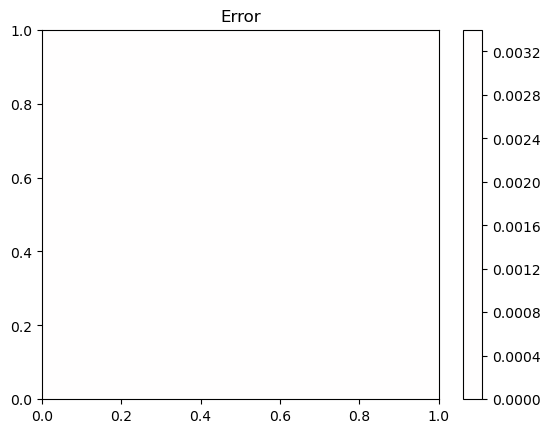

In [7]:
'''Error'''
u_err = np.abs(u_ref[:,:] - u_num[:,:])/ np.abs(np.max(u_ref[:,:]))
plt.figure()
plt.contourf(X, Y, u_err, levels=16, cmap='bwr',  vmin=-1, vmax=1)
plt.colorbar()
plt.title('Error') 

print("Maximum error: ", np.max(u_err))